In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression

%matplotlib inline

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df = pd.read_csv('../data/globalterrorismdb_0617dist.csv', encoding='ISO-8859-1', low_memory=False)

df.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [3]:
df.rename(columns={'iyear':'Year','imonth':'Month','iday':'Day','city': 'City', 'country_txt':'Country','region_txt':'Region','attacktype1_txt':'AttackTypeText','attacktype1': 'AttackType','target1':'Target','nkill':'Killed','nwound':'Wounded','summary':'Summary','gname':'Group','targtype1_txt':'Target_Type','weaptype1_txt':'Weapon_Type','motive':'Motive', 'latitude': 'Latitude', 'longitude': 'Longitude', 'casualities': "Casualties", 'ransom': 'Ransom', 'ransomamt': 'Ransom_Amount', 'ransompaid': 'Ransom_Paid'},inplace=True)
df.rename(columns={'iyear':'Year','imonth':'Month','iday':'Day','country_txt':'Country','region_txt':'Region','attacktype1_txt':'AttackTypeText','attacktype1': 'AttackType','target1':'Target','nkill':'Killed','nwound':'Wounded','summary':'Summary','gname':'Group','targtype1_txt':'Target_Type','weaptype1_txt':'Weapon_Type','motive':'Motive', 'latitude': 'Latitude', 'longitude': 'Longitude', 'success': 'Success'},inplace=True)


In [4]:
year_1993 = df[df['Year'] == 1993]

In [5]:
year_1993.head()
#just double checking 

,eventid,Year,Month,Day,approxdate,extended,resolution,country,Country,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related


In [6]:
terror=df[['Year','Month','Day','Country','Region','City','Latitude','Longitude','AttackTypeText','AttackType','Killed','Wounded','Target','Summary','Group','Target_Type','Weapon_Type','Motive', 'Success','Ransom','Ransom_Amount', 'Ransom_Paid', 'INT_ANY']].copy()
terror['Casualties']=terror['Killed']+terror['Wounded']
terror.head(5)

,Year,Month,Day,Country,Region,City,Latitude,Longitude,AttackTypeText,AttackType,...,Group,Target_Type,Weapon_Type,Motive,Success,Ransom,Ransom_Amount,Ransom_Paid,INT_ANY,Casualties
0,1970,7,2,Dominican Republic,Central America & Caribbean,Santo Domingo,18.456792,-69.951164,Assassination,1,...,MANO-D,Private Citizens & Property,Unknown,NaN,1,0.0,NaN,NaN,0,1.0
1,1970,0,0,Mexico,North America,Mexico city,19.432608,-99.133207,Hostage Taking (Kidnapping),6,...,23rd of September Communist League,Government (Diplomatic),Unknown,NaN,1,1.0,800000.0,NaN,1,0.0
2,1970,1,0,Philippines,Southeast Asia,Unknown,15.478598,120.599741,Assassination,1,...,Unknown,Journalists & Media,Unknown,NaN,1,0.0,NaN,NaN,1,1.0
3,1970,1,0,Greece,Western Europe,Athens,37.983773,23.728157,Bombing/Explosion,3,...,Unknown,Government (Diplomatic),Explosives/Bombs/Dynamite,NaN,1,0.0,NaN,NaN,1,NaN
4,1970,1,0,Japan,East Asia,Fukouka,33.580412,130.396361,Facility/Infrastructure Attack,7,...,Unknown,Government (Diplomatic),Incendiary,NaN,1,0.0,NaN,NaN,1,NaN


In [7]:
terror.AttackTypeText.unique()


array(['Assassination', 'Hostage Taking (Kidnapping)',
       'Bombing/Explosion', 'Facility/Infrastructure Attack',
       'Armed Assault', 'Hijacking', 'Unknown', 'Unarmed Assault',
       'Hostage Taking (Barricade Incident)'], dtype=object)

# Bombings in 1993 - AttackType 3

In [8]:
bombings = terror[terror['AttackTypeText'] == 'Bombing/Explosion'].copy()

In [9]:
blank_year = pd.DataFrame()
blank_year["Year"] = bombings["Year"].value_counts().index
blank_year['Count'] = bombings['Year'].value_counts().values

In [10]:
X = blank_year['Year'].values.reshape(-1,1)
y = blank_year['Count']

## Predict with Linear Regression

In [11]:
lin_reg = LinearRegression()
lin_reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [12]:
guess_1993 = lin_reg.predict([[1993]])
guess_1993

array([1805.93478261])

In [13]:
lin_reg.intercept_

-188424.8551110083

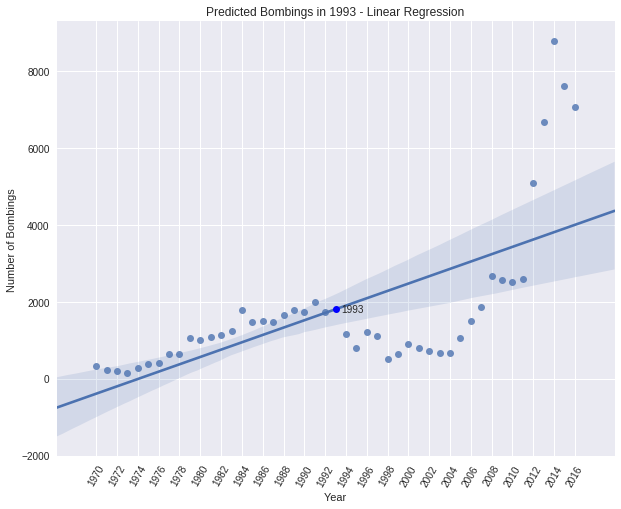

In [14]:
plt.figure(figsize=(10,8))
sns.regplot(blank_year['Year'], blank_year['Count'])
plt.plot(1993, 1806, marker='o', linestyle='-', color='blue')
plt.text(1993.5, 1725, "1993")
plt.title("Predicted Bombings in 1993 - Linear Regression")
plt.ylabel("Number of Bombings")
plt.xlabel("Year")
plt.xticks(np.arange(min(blank_year['Year']), max(blank_year['Year']) + 2, 2), rotation=60);

# Assassinations in 1993 - AttackType 1


In [15]:
assassinations = terror[terror['AttackTypeText'] == 'Assassination'].copy()

In [16]:
blank_assassinations = pd.DataFrame()
blank_assassinations["Year"] = assassinations["Year"].value_counts().index
blank_assassinations['Count'] = assassinations['Year'].value_counts().values

In [17]:
X = blank_assassinations['Year'].values.reshape(-1,1)
y = blank_assassinations['Count']

## Predict with Linear Regression 

In [18]:
lin_reg = LinearRegression()
lin_reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [19]:
guess_1993 = lin_reg.predict([[1993]])
guess_1993

array([400.04347826])

In [20]:
lin_reg.intercept_

-9140.22259481961

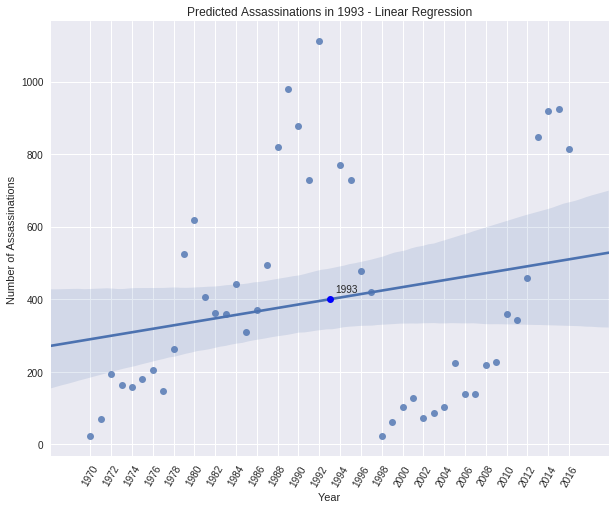

In [21]:
plt.figure(figsize=(10,8))
sns.regplot(blank_assassinations['Year'], blank_assassinations['Count'])
plt.plot(1993, 400, marker='o', linestyle='-', color='blue')
plt.text(1993.5, 420, "1993")
plt.title("Predicted Assassinations in 1993 - Linear Regression")
plt.ylabel("Number of Assassinations")
plt.xlabel("Year")
plt.xticks(np.arange(min(blank_assassinations['Year']), max(blank_assassinations['Year']) + 2, 2), rotation=60);

# Predicting Armed Assault in 1993 - AttackType 2

In [22]:
assault = terror[terror['AttackTypeText'] == 'Armed Assault'].copy()
blank_assault = pd.DataFrame()
blank_assault["Year"] = assault["Year"].value_counts().index
blank_assault['Count'] = assault['Year'].value_counts().values

In [23]:
X = blank_assault['Year'].values.reshape(-1,1)
y = blank_assault['Count']

## Predict with Linear Regression

In [24]:
lin_reg = LinearRegression()
lin_reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [25]:
guess_1993 = lin_reg.predict([[1993]])
guess_1993

array([874.41304348])

In [26]:
lin_reg.intercept_

-82517.70328399629

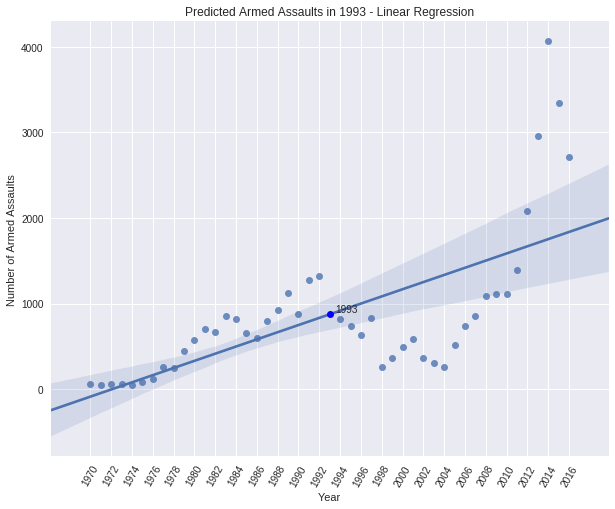

In [27]:
plt.figure(figsize=(10,8))
sns.regplot(blank_assault['Year'], blank_assault['Count'])
plt.plot(1993, 875, marker='o', linestyle='-', color='blue')
plt.text(1993.5, 900, "1993")
plt.title("Predicted Armed Assaults in 1993 - Linear Regression")
plt.ylabel("Number of Armed Assaults")
plt.xlabel("Year")
plt.xticks(np.arange(min(blank_assault['Year']), max(blank_assault['Year']) + 2, 2), rotation=60);

# Predicting Hijackings in 1993 - AttackType 4

In [28]:
hijacking = terror[terror['AttackTypeText'] == 'Hijacking'].copy()
blank_hijacking = pd.DataFrame()
blank_hijacking["Year"] = hijacking["Year"].value_counts().index
blank_hijacking['Count'] = hijacking['Year'].value_counts().values

X = blank_hijacking['Year'].values.reshape(-1,1)
y = blank_hijacking['Count']

## Predict with Linear Regression

In [29]:
lin_reg = LinearRegression()
lin_reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [30]:
guess_1993 = lin_reg.predict([[1993]])
guess_1993

array([13.19256091])

In [31]:
lin_reg.intercept_

-562.7523982999393

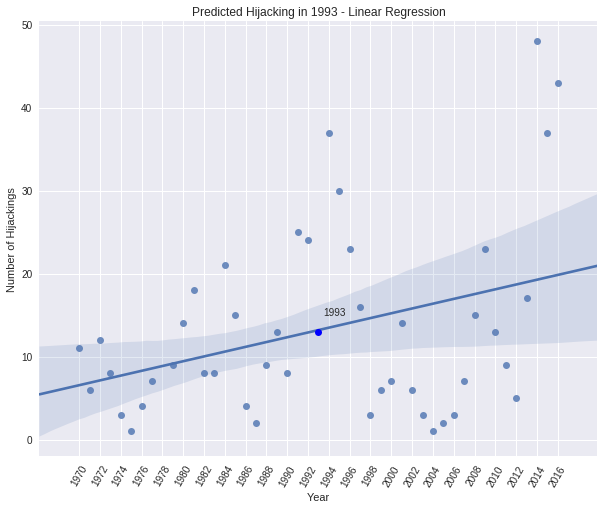

In [32]:
plt.figure(figsize=(10,8))
sns.regplot(blank_hijacking['Year'], blank_hijacking['Count'])
plt.plot(1993, 13, marker='o', linestyle='-', color='blue')
plt.text(1993.5, 15, "1993")
plt.title("Predicted Hijacking in 1993 - Linear Regression")
plt.ylabel("Number of Hijackings")
plt.xlabel("Year")
plt.xticks(np.arange(min(blank_hijacking['Year']), max(blank_hijacking['Year']) + 2, 2), rotation=60);

# Predicting Hostage Taking (Barricade Incident)  in 1993 - AttackType 5

In [33]:
hostage = terror[terror['AttackTypeText'] == 'Hostage Taking (Barricade Incident)'].copy()
blank_hostage = pd.DataFrame()
blank_hostage["Year"] = hostage["Year"].value_counts().index
blank_hostage['Count'] = hostage['Year'].value_counts().values

X = blank_hostage['Year'].values.reshape(-1,1)
y = blank_hostage['Count']

## Predict with Linear Regression 

In [34]:
lin_reg = LinearRegression()
lin_reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [35]:
guess_1993 = lin_reg.predict([[1993]])
guess_1993

array([20.50964492])

In [36]:
lin_reg.intercept_

-29.242245571867834

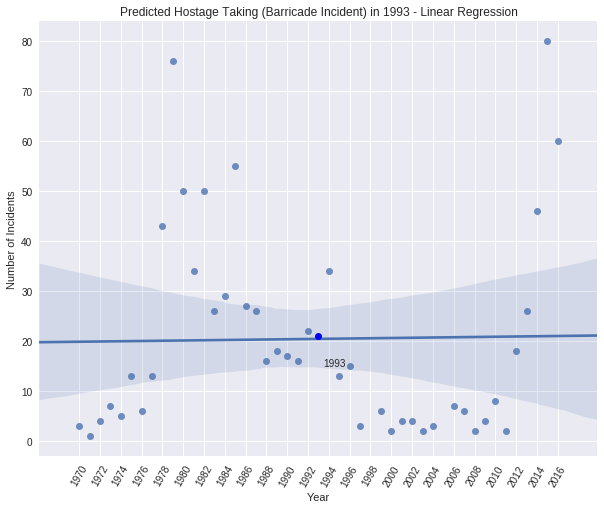

In [37]:
plt.figure(figsize=(10,8))
sns.regplot(blank_hostage['Year'], blank_hostage['Count'])
plt.plot(1993, 21, marker='o', linestyle='-', color='blue')
plt.text(1993.5, 15, "1993")
plt.title("Predicted Hostage Taking (Barricade Incident) in 1993 - Linear Regression")
plt.ylabel("Number of Incidents")
plt.xlabel("Year")
plt.xticks(np.arange(min(blank_hostage['Year']), max(blank_hostage['Year']) + 2, 2), rotation=60);

# Predicting Hostage Taking (Kidnapping) in 1993 - AttackType 6

In [38]:
kidnapping = terror[terror['AttackTypeText'] == 'Hostage Taking (Kidnapping)'].copy()
blank_kidnapping = pd.DataFrame()
blank_kidnapping["Year"] = kidnapping["Year"].value_counts().index
blank_kidnapping['Count'] = kidnapping['Year'].value_counts().values

X = blank_kidnapping['Year'].values.reshape(-1,1)
y = blank_kidnapping['Count']

## Predict with Linear Regression 

In [39]:
lin_reg = LinearRegression()
lin_reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [40]:
guess_1993 = lin_reg.predict([[1993]])
guess_1993

array([222.45652174])

In [41]:
lin_reg.intercept_

-26982.40830249769

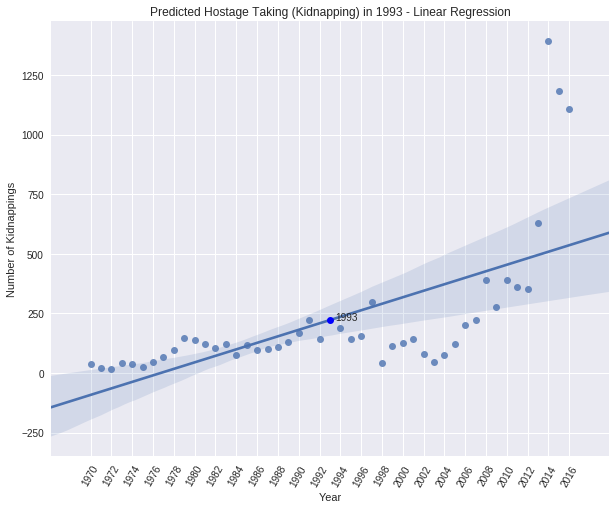

In [42]:
plt.figure(figsize=(10,8))
sns.regplot(blank_kidnapping['Year'], blank_kidnapping['Count'])
plt.plot(1993, 222, marker='o', linestyle='-', color='blue')
plt.text(1993.5, 220, "1993")
plt.title("Predicted Hostage Taking (Kidnapping) in 1993 - Linear Regression")
plt.ylabel("Number of Kidnappings")
plt.xlabel("Year")
plt.xticks(np.arange(min(blank_kidnapping['Year']), max(blank_kidnapping['Year']) + 2, 2), rotation=60);

# Predicting Facility / Infrastructure Attacks in 1993 - AttackType 7

In [43]:
facility = terror[terror['AttackTypeText'] == 'Facility/Infrastructure Attack'].copy()
blank_facility = pd.DataFrame()
blank_facility["Year"] = facility["Year"].value_counts().index
blank_facility['Count'] = facility['Year'].value_counts().values

X = blank_facility['Year'].values.reshape(-1,1)
y = blank_facility['Count']

## Predict with Linear Regression 


In [44]:
lin_reg = LinearRegression()
lin_reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [45]:
guess_1993 = lin_reg.predict([[1993]])
guess_1993

array([208.2826087])

In [46]:
lin_reg.intercept_

-13573.100370027743

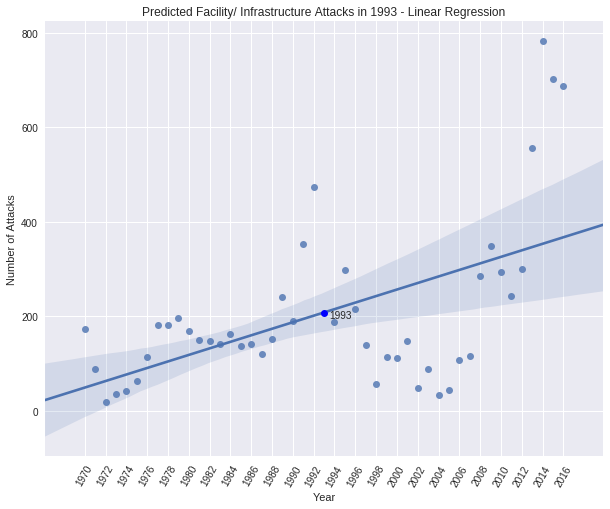

In [47]:
plt.figure(figsize=(10,8))
sns.regplot(blank_facility['Year'], blank_facility['Count'])
plt.plot(1993, 208, marker='o', linestyle='-', color='blue')
plt.text(1993.5, 195, "1993")
plt.title("Predicted Facility/ Infrastructure Attacks in 1993 - Linear Regression")
plt.ylabel("Number of Attacks")
plt.xlabel("Year")
plt.xticks(np.arange(min(blank_facility['Year']), max(blank_facility['Year']) + 2, 2), rotation=60);

# Predicting Unarmed Assault in 1993 - AttackType 8

In [48]:
unarmed = terror[terror['AttackTypeText'] == 'Unarmed Assault'].copy()
blank_unarmed = pd.DataFrame()
blank_unarmed["Year"] = unarmed["Year"].value_counts().index
blank_unarmed['Count'] = unarmed['Year'].value_counts().values

X = blank_unarmed['Year'].values.reshape(-1,1)
y = blank_unarmed['Count']

## Predict with Linear Regression 

In [49]:
lin_reg = LinearRegression()
lin_reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [50]:
guess_1993 = lin_reg.predict([[1993]])
guess_1993

array([19.89079731])

In [51]:
lin_reg.intercept_

-1988.289988676436

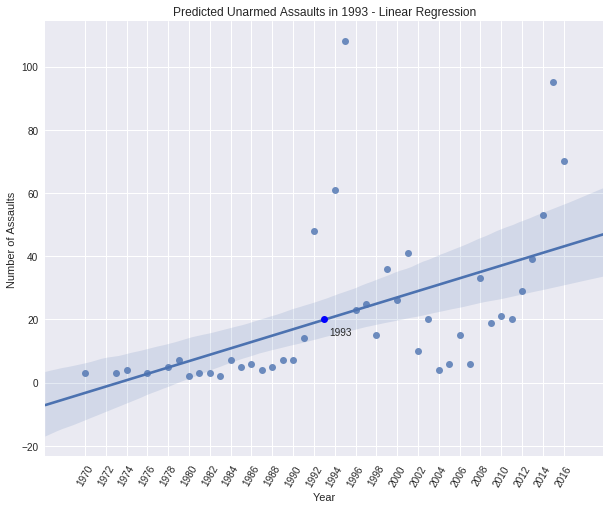

In [52]:
plt.figure(figsize=(10,8))
sns.regplot(blank_unarmed['Year'], blank_unarmed['Count'])
plt.plot(1993, 20, marker='o', linestyle='-', color='blue')
plt.text(1993.5, 15, "1993")
plt.title("Predicted Unarmed Assaults in 1993 - Linear Regression")
plt.ylabel("Number of Assaults")
plt.xlabel("Year")
plt.xticks(np.arange(min(blank_unarmed['Year']), max(blank_unarmed['Year']) + 2, 2), rotation=60);

# Predicting Unknown Attacks in 1993 - AttackType 9

In [53]:
unk = terror[terror['AttackTypeText'] == 'Unknown'].copy()
blank_unk = pd.DataFrame()
blank_unk["Year"] = unk["Year"].value_counts().index
blank_unk['Count'] = unk['Year'].value_counts().values

X = blank_unk['Year'].values.reshape(-1,1)
y = blank_unk['Count']

## Predict with Linear Regression 


In [54]:
lin_reg = LinearRegression()
lin_reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [55]:
guess_1993 = lin_reg.predict([[1993]])
guess_1993

array([139.67391304])

In [56]:
lin_reg.intercept_

-15065.708487511567

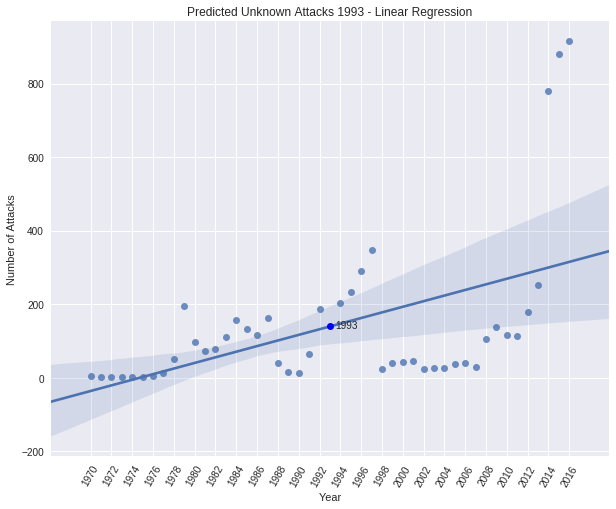

In [57]:
plt.figure(figsize=(10,8))
sns.regplot(blank_unk['Year'], blank_unk['Count'])
plt.plot(1993, 140, marker='o', linestyle='-', color='blue')
plt.text(1993.5, 135, "1993")
plt.title("Predicted Unknown Attacks 1993 - Linear Regression")
plt.ylabel("Number of Attacks")
plt.xlabel("Year")
plt.xticks(np.arange(min(blank_unk['Year']), max(blank_unk['Year']) + 2, 2), rotation=60);